In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%config Completer.use_jedi = False

### 데이터 다운로드, 전처리 및 분석

In [3]:
# stanford dog breed 데이터 세트 다운로드 
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
# 현재 디렉토리인 /kaggle/working에 바로 압축 해제 
!ls; tar -xvf images.tar

--2024-04-13 05:09:24--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: 'images.tar'

images.tar          100%[===================>] 756.82M  10.5MB/s    in 53s     

2024-04-13 05:10:17 (14.3 MB/s) - 'images.tar' saved [793579520/793579520]

images.tar
Images/
Images/n02085620-Chihuahua/
Images/n02085620-Chihuahua/n02085620_10621.jpg
Images/n02085620-Chihuahua/n02085620_10976.jpg
Images/n02085620-Chihuahua/n02085620_11238.jpg
Images/n02085620-Chihuahua/n02085620_11258.jpg
Images/n02085620-Chihuahua/n02085620_11337.jpg
Images/n02085620-Chihuahua/n02085620_1152.jpg
Images/n02085620-Chihuahua/n02085620_11696.jpg
Images/n02085620-Chihuahua/n02085620_11818.jpg
Images/n02085620-Chihuahua/n02085620_11948.jpg
Images/n02085620-

In [4]:
!ls; pwd

Images	images.tar
/kaggle/working


In [5]:
# working 아래에 images 디렉토리로 이동
!cd /kaggle/working/Images;ls

n02085620-Chihuahua			  n02100583-vizsla
n02085782-Japanese_spaniel		  n02100735-English_setter
n02085936-Maltese_dog			  n02100877-Irish_setter
n02086079-Pekinese			  n02101006-Gordon_setter
n02086240-Shih-Tzu			  n02101388-Brittany_spaniel
n02086646-Blenheim_spaniel		  n02101556-clumber
n02086910-papillon			  n02102040-English_springer
n02087046-toy_terrier			  n02102177-Welsh_springer_spaniel
n02087394-Rhodesian_ridgeback		  n02102318-cocker_spaniel
n02088094-Afghan_hound			  n02102480-Sussex_spaniel
n02088238-basset			  n02102973-Irish_water_spaniel
n02088364-beagle			  n02104029-kuvasz
n02088466-bloodhound			  n02104365-schipperke
n02088632-bluetick			  n02105056-groenendael
n02089078-black-and-tan_coonhound	  n02105162-malinois
n02089867-Walker_hound			  n02105251-briard
n02089973-English_foxhound		  n02105412-kelpie
n02090379-redbone			  n02105505-komondor
n02090622-borzoi			  n02105641-Old_English_sheepdog
n02090721-Irish_wolfhound		  n02105855-Shetland_sheepdog
n02091032-Itali

### 이미지 파일들의 디렉토리와 파일명을 기반으로 메타 정보인 이미지 절대경로, 레이블을 DataFrame으로 생성
* 이미지 디렉토리를 보면 /kaggle/working/Images/ 아래에 품종별로 구분되어 있음
* 레이블 값은 이미지 파일의 절대경로에서 이미지 파일 바로 위에 있는 서브 디렉토리를 가공해 생성 

In [6]:
# 기존 directory 안에 있는 파일에서 품종 이름을 뽑아내기 위한 작업이다.
start_pos = '/kaggle/working/Images/n02109961-Eskimo_dog/n02109961_12338.jpg'.find('/', 20)
end_pos = '/kaggle/working/Images/n02109961-Eskimo_dog/n02109961_12338.jpg'.rfind('/')

imsi_breed = '/kaggle/working/Images/n02109961-Eskimo_dog/n02109961_12338.jpg'[start_pos+1: end_pos]
print(imsi_breed)

breed = imsi_breed[imsi_breed.find('-')+1:]
print(breed)

n02109961-Eskimo_dog
Eskimo_dog


In [7]:
IMAGE_DIR = '/kaggle/working/Images'

def make_dogbreed_dataframe(image_dir=IMAGE_DIR):
    paths = []
    label_gubuns = []
    for dirname, _, filenames in os.walk(image_dir):
        for filename in filenames:
            if '.jpg' in filename:
                # 이미지 파일 절대경로를 file_path에 할당
                file_path = dirname+'/'+filename
                paths.append(file_path)
                # 이미지 파일의 절대 경로에서 레이블명 생성을 위한 1차 추출
                start_pos = file_path.find('/', 20)
                end_pos = file_path.rfind('/')
                imsi_breed = file_path[start_pos+1:end_pos]
                # 1차 추출된 데이터를 기반으로 2차 추출
                breed = imsi_breed[imsi_breed.find('-')+1:]
                # 추출한 품종명을 label_gubuns에 할당
                label_gubuns.append(breed)
    
    # dataframe 생성
    data_df = pd.DataFrame({'path':paths, 'label':label_gubuns})
    return data_df
        

In [8]:
pd.set_option('display.max_colwidth', 200)
data_df = make_dogbreed_dataframe()
print('data_df shape:', data_df.shape)
data_df.head()

data_df shape: (20580, 2)


path  \
0  /kaggle/working/Images/n02112706-Brabancon_griffon/n02112706_1418.jpg   
1  /kaggle/working/Images/n02112706-Brabancon_griffon/n02112706_1700.jpg   
2   /kaggle/working/Images/n02112706-Brabancon_griffon/n02112706_223.jpg   
3   /kaggle/working/Images/n02112706-Brabancon_griffon/n02112706_540.jpg   
4   /kaggle/working/Images/n02112706-Brabancon_griffon/n02112706_256.jpg   

               label  
0  Brabancon_griffon  
1  Brabancon_griffon  
2  Brabancon_griffon  
3  Brabancon_griffon  
4  Brabancon_griffon

### Dog Breed의 개별 분포도 확인

In [9]:
print(data_df.shape)
# breed 건수 확인
data_df['label'].value_counts()

(20580, 2)


label
Maltese_dog             252
Afghan_hound            239
Scottish_deerhound      232
Pomeranian              219
Bernese_mountain_dog    218
                       ... 
Doberman                150
affenpinscher           150
Eskimo_dog              150
Pekinese                149
redbone                 148
Name: count, Length: 120, dtype: int64

In [10]:
data_df['label'].value_counts().index.tolist()

['Maltese_dog',
 'Afghan_hound',
 'Scottish_deerhound',
 'Pomeranian',
 'Bernese_mountain_dog',
 'Samoyed',
 'Irish_wolfhound',
 'Shih-Tzu',
 'Great_Pyrenees',
 'Leonberg',
 'basenji',
 'Tibetan_terrier',
 'EntleBucher',
 'Sealyham_terrier',
 'Airedale',
 'pug',
 'Saluki',
 'Lakeland_terrier',
 'cairn',
 'papillon',
 'chow',
 'Australian_terrier',
 'Norwegian_elkhound',
 'Newfoundland',
 'beagle',
 'Siberian_husky',
 'Blenheim_spaniel',
 'Ibizan_hound',
 'bloodhound',
 'whippet',
 'Lhasa',
 'Japanese_spaniel',
 'Norwich_terrier',
 'miniature_pinscher',
 'silky_terrier',
 'Bedlington_terrier',
 'Boston_bull',
 'Italian_greyhound',
 'Pembroke',
 'Dandie_Dinmont',
 'Kerry_blue_terrier',
 'malamute',
 'basset',
 'Rhodesian_ridgeback',
 'Norfolk_terrier',
 'Border_terrier',
 'toy_terrier',
 'bluetick',
 'Labrador_retriever',
 'Saint_Bernard',
 'Irish_terrier',
 'Old_English_sheepdog',
 'West_Highland_white_terrier',
 'African_hunting_dog',
 'Greater_Swiss_Mountain_dog',
 'Chesapeake_Bay_ret

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119]),
 [Text(0, 0, 'Brabancon_griffon'),
  Text(1, 0, 'Scotch_terrier'),
  Text(2, 0, 'Japanese_spaniel'),
  Text(3, 0, 'Pembroke'),
  Text(4, 0, 'miniature_pinscher'),
  Text(5, 0, 'Tibetan_mastiff'),
  Text(6, 0, 'borzoi'),
  Text(7, 0, 'Tibetan_terrier'),
  Text(8, 0, 'Appenzeller'),
  Text(9, 0, 'bluetick'),
  Text(10,

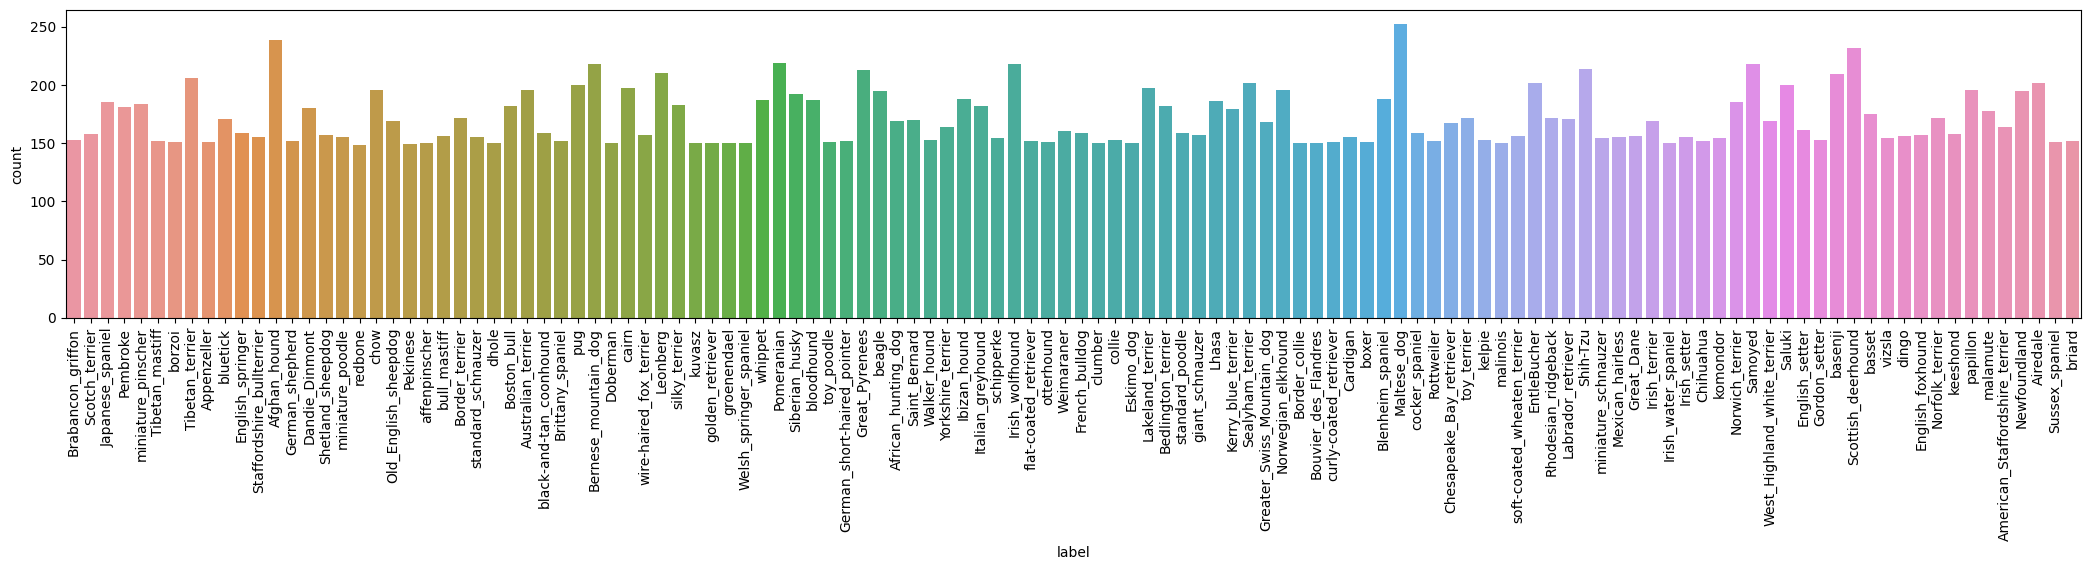

In [11]:
# 막대 그래프 형태로 breed별 건수 확인
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(26,4))

sns.countplot(data = data_df, x='label')
plt.xticks(rotation=90)

### Dog Breed 이미지 보기

In [12]:
import cv2

# dog breed별로 image를 보기 위한 utility 함수 생성.
def show_grid_image(image_path_list, ncols=6, title=None):
    fig, axs = plt.subplots(figsize=(22,4), ncols=ncols, nrows=1)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[i]), cv2.COLOR_BGR2RGB)
        axs[i].imshow(image)
        axs[i].set_title(title)

In [13]:
breed_image_list_01 = data_df[data_df['label']=='Staffordshire_bullterrier']['path'].iloc[:6].tolist()
breed_image_list_02 = data_df[data_df['label']=='Japanese_spaniel']['path'].iloc[:6].tolist()

print(breed_image_list_01,'\n')
print(breed_image_list_02)

['/kaggle/working/Images/n02093256-Staffordshire_bullterrier/n02093256_1487.jpg', '/kaggle/working/Images/n02093256-Staffordshire_bullterrier/n02093256_5325.jpg', '/kaggle/working/Images/n02093256-Staffordshire_bullterrier/n02093256_6992.jpg', '/kaggle/working/Images/n02093256-Staffordshire_bullterrier/n02093256_1134.jpg', '/kaggle/working/Images/n02093256-Staffordshire_bullterrier/n02093256_13267.jpg', '/kaggle/working/Images/n02093256-Staffordshire_bullterrier/n02093256_5654.jpg'] 

['/kaggle/working/Images/n02085782-Japanese_spaniel/n02085782_3019.jpg', '/kaggle/working/Images/n02085782-Japanese_spaniel/n02085782_2293.jpg', '/kaggle/working/Images/n02085782-Japanese_spaniel/n02085782_1350.jpg', '/kaggle/working/Images/n02085782-Japanese_spaniel/n02085782_4458.jpg', '/kaggle/working/Images/n02085782-Japanese_spaniel/n02085782_230.jpg', '/kaggle/working/Images/n02085782-Japanese_spaniel/n02085782_3727.jpg']


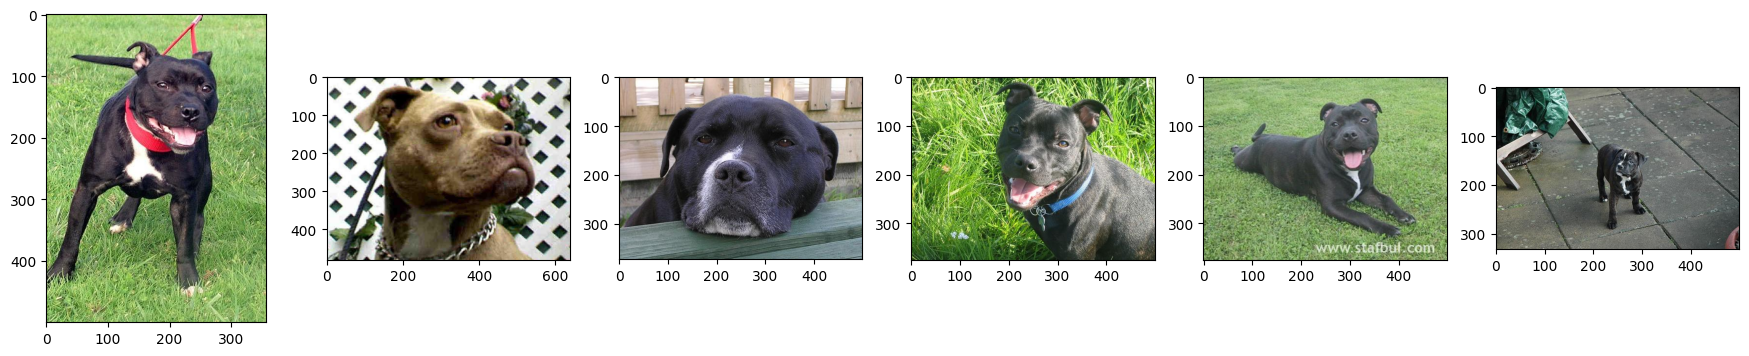

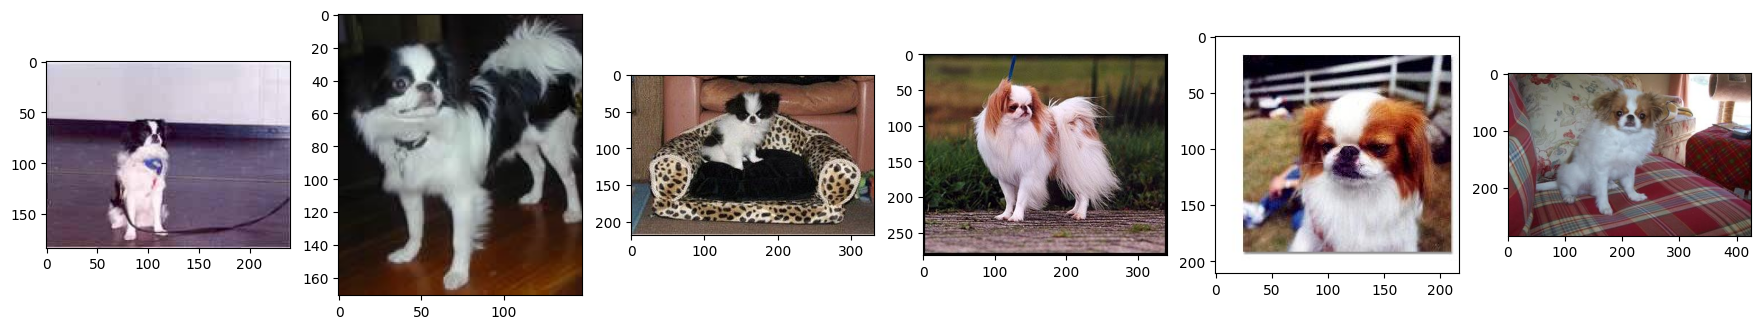

In [14]:
show_grid_image(breed_image_list_01)

show_grid_image(breed_image_list_02)

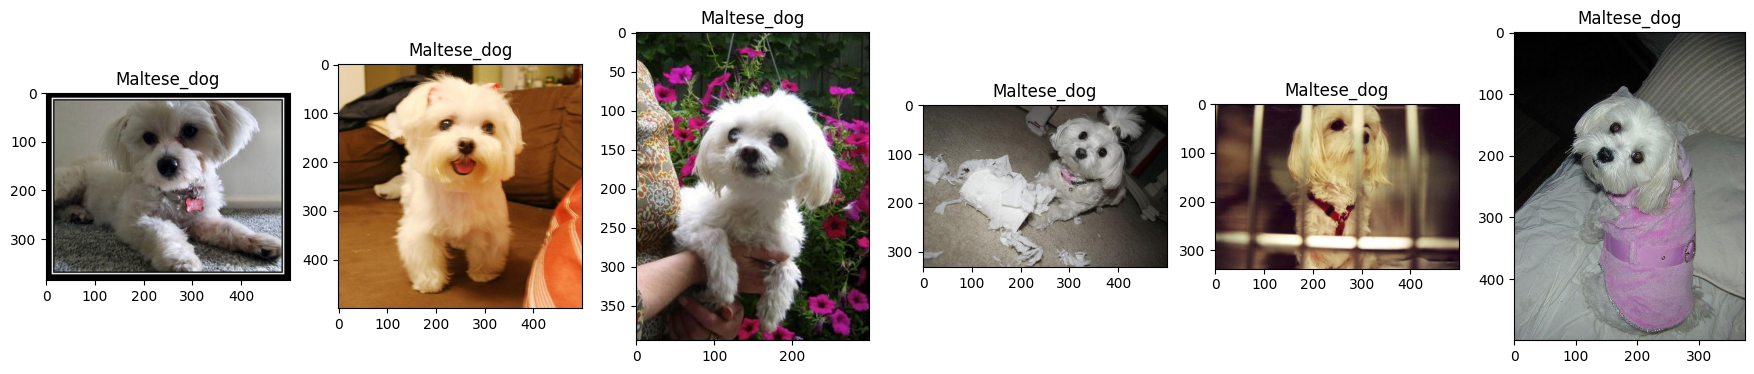

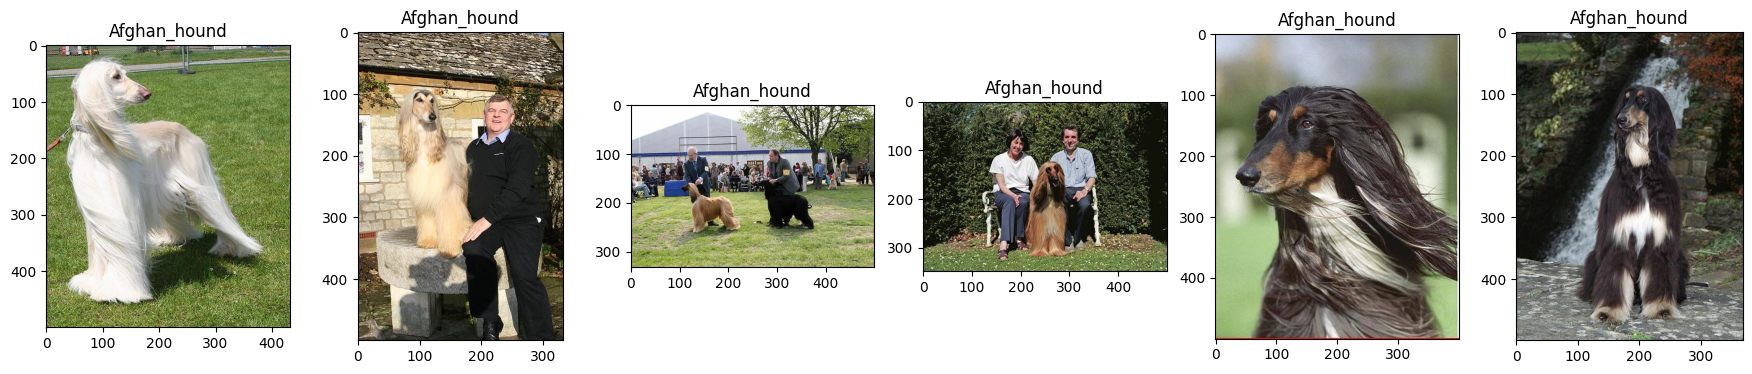

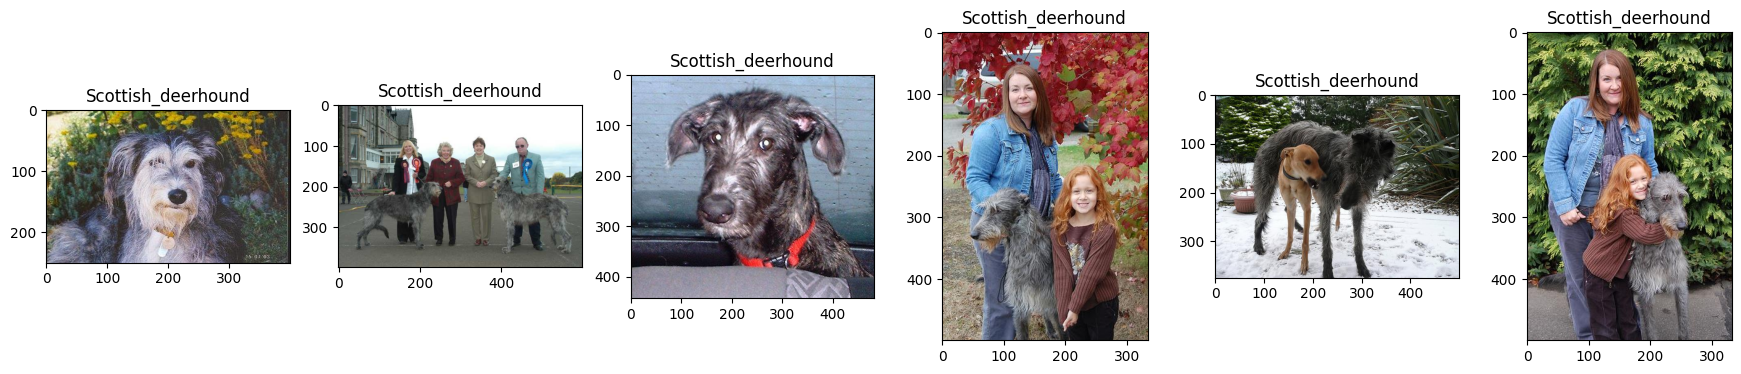

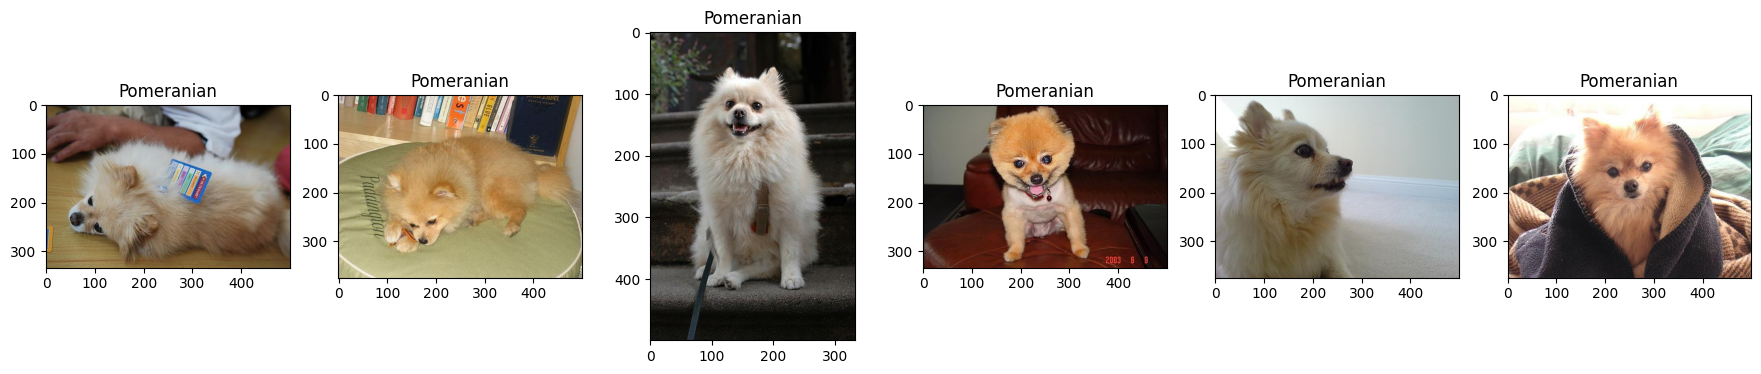

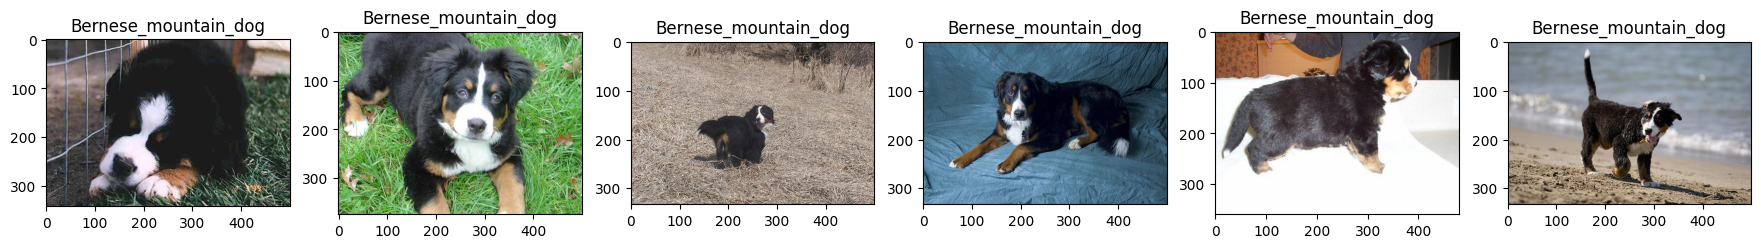

In [15]:
# 여러 품종 이미지 한꺼번에 보기

breed_list = data_df['label'].value_counts().index.tolist()

for iter_cnt, breed in enumerate(breed_list):
    breed_image_list = data_df[data_df['label'] == breed]['path'].iloc[:6].tolist()
    show_grid_image(breed_image_list,ncols=6 ,title=breed)
    if iter_cnt == 4:
        break

### 이미지 사이즈를 224x224로 고정하고 Augmentation 적용한 이미지 보기

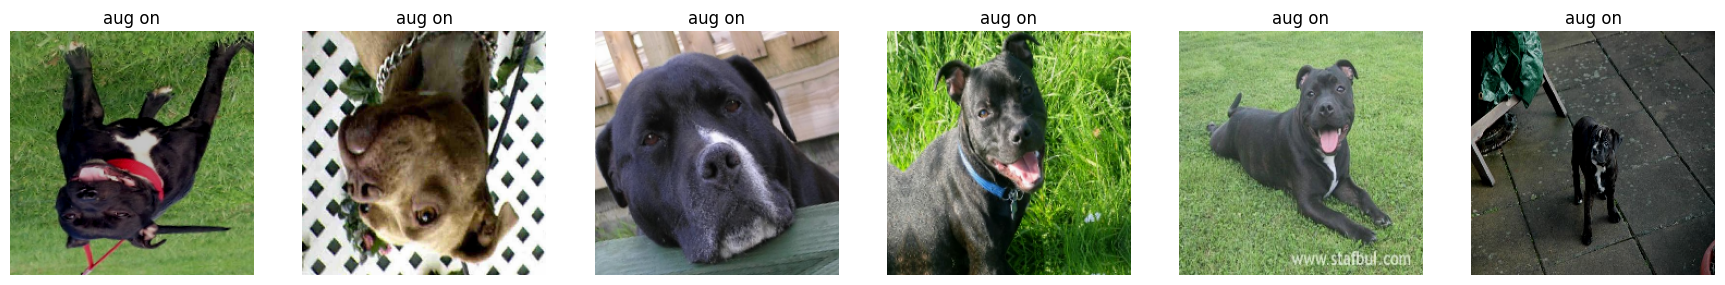

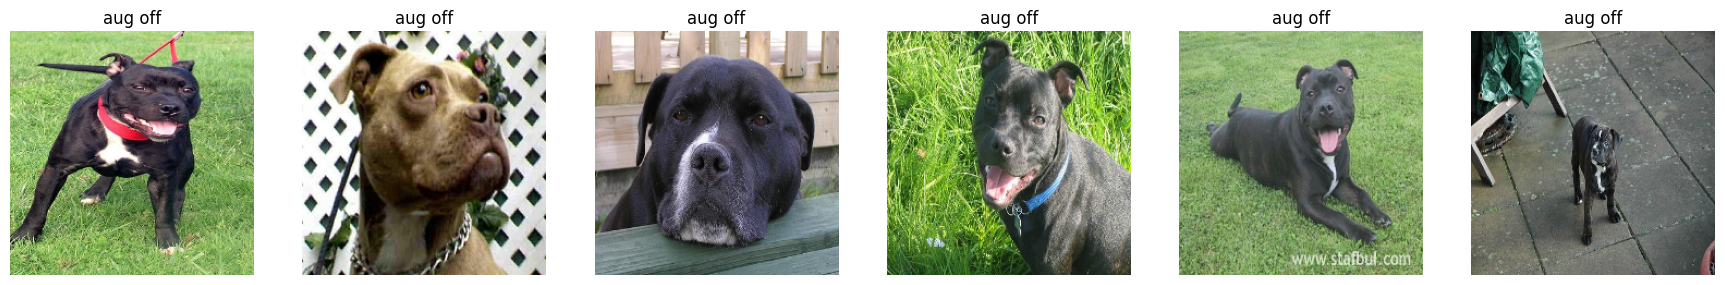

In [16]:
import albumentations as A

# crop의 경우 이미지 중앙에 사람이 있을 경우 개가 잘리고 사람만 남을 수 있으니 이에 유의한다.
image_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5)
])

def show_grid_images(image_path_list, augmentor=None, ncols=6, title=None):
    fig, axs = plt.subplots(figsize=(22,4), ncols=6, nrows=1)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[i]), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224,224))
        if augmentor is not None:
            image = image_augmentor(image=image)['image']
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(title)
        
breed_image_list_01 = data_df[data_df['label']=='Staffordshire_bullterrier']['path'].iloc[:6].tolist()
show_grid_images(breed_image_list_01, augmentor=image_augmentor, title='aug on')
show_grid_images(breed_image_list_01, augmentor=None, title='aug off')

### 전체 DataFrame을 학습과 테스트용으로 분리하고, 학습용은 다시 학습용과 검증용으로 분리한다.
* sklearn의 train_test_split()을 이용해 전체 데이터 40%를 테스트 데이터로 할당한다.

In [17]:
data_df.head()

path  \
0  /kaggle/working/Images/n02112706-Brabancon_griffon/n02112706_1418.jpg   
1  /kaggle/working/Images/n02112706-Brabancon_griffon/n02112706_1700.jpg   
2   /kaggle/working/Images/n02112706-Brabancon_griffon/n02112706_223.jpg   
3   /kaggle/working/Images/n02112706-Brabancon_griffon/n02112706_540.jpg   
4   /kaggle/working/Images/n02112706-Brabancon_griffon/n02112706_256.jpg   

               label  
0  Brabancon_griffon  
1  Brabancon_griffon  
2  Brabancon_griffon  
3  Brabancon_griffon  
4  Brabancon_griffon

In [18]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_df, test_size=0.4, stratify=data_df['label'], random_state=42)

print(train_df.shape, test_df.shape)

(12348, 2) (8232, 2)


In [19]:
# train, test data 구분 비율이다.
# 위에서 stratify의 data_df['label']을 기준으로 데이터를 분류해서 label 별로 구분 비율이 일정하다.


print(train_df['label'].value_counts()/train_df.shape[0],'\n')
print(test_df['label'].value_counts()/test_df.shape[0])

label
Maltese_dog               0.012229
Afghan_hound              0.011581
Scottish_deerhound        0.011257
Pomeranian                0.010690
Bernese_mountain_dog      0.010609
                            ...   
golden_retriever          0.007289
clumber                   0.007289
Welsh_springer_spaniel    0.007289
groenendael               0.007289
redbone                   0.007208
Name: count, Length: 120, dtype: float64 

label
Maltese_dog             0.012269
Afghan_hound            0.011662
Scottish_deerhound      0.011297
Samoyed                 0.010569
Bernese_mountain_dog    0.010569
                          ...   
Border_collie           0.007289
dhole                   0.007289
borzoi                  0.007289
redbone                 0.007167
Pekinese                0.007167
Name: count, Length: 120, dtype: float64


In [20]:
# Dataframe에서 numpy array로 변환
train_path = train_df['path'].values
train_label = pd.get_dummies(train_df['label']).values

test_path = test_df['path'].values
test_label = pd.get_dummies(test_df['label']).values

# 학습 데이터를 다시 학습과 검증용으로 분리

tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, stratify=train_label, test_size=0.2, random_state=42)

print(tr_path.shape, tr_label.shape)
print(val_path.shape, val_label.shape)
print(test_path.shape, test_label.shape)

(9878,) (9878, 120)
(2470,) (2470, 120)
(8232,) (8232, 120)


### Sequence 기반의 Dataset 생성
* image size 인자를 통해 여러 모델에 대응할 수 있도록 설계
* 예를 들면 keras efficientb0는 224x224 이미지로, efficientb1은 240x240 이미지로 최적화를 진행한다
* Albumentation의 crop 등을 적용하기 위해 augmentation 적용 후 cv2.resize() 적용
* augmentation은 기본적인 좌우반전부터 시작

In [21]:
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import sklearn
import cv2

BATCH_SIZE = 64
IMAGE_SIZE = 224

class Breed_Dataset(Sequence):
    def __init__(self, image_filenames, labels, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 가져올 데이터 batch 건수
        augmentor: albumentation 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당
        self.image_filenames = image_filenames
        self.labels = labels
        self.image_size = image_size
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle = shuffle
        self.pre_func = pre_func
        
    # Sequence를 상속받은 dataset은 batch_size 단위로 입력된 데이터를 처리한다.
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size 단위로 몇 번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size 단위로 데이터를 몇 번 갖고와야 하는지 계산
        return int(np.ceil(len(self.labels)/ self.batch_size))
    
    def __getitem__(self, index):
        # index는 몇 번째 batch인지 나타낸다
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        image_batch = np.zeros((image_name_batch.shape[0], self.image_size, self.image_size, 3), dtype='float32')
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor로 이미지 변환
        # albmentation은 개별 이미지만 변환할 수 있으므로 batch_size에 따라 뽑이온 이미지를 하나씩 변환해줘야 한다.
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            # crop과 같이 잘린 이미지가 원본 이미지와 다르게 나타나는 경우가 있으므로 resize 적용
            image = cv2.resize(image, (self.image_size, self.image_size))
            # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용해 scaling 적용
            if self.pre_func is not None:
                image = self.pre_func(image)
                
            image_batch[image_index] = image
            
        return image_batch, label_batch
    
    # epoch가 한 번 수행이 끝날 때 모델의 fit()에서 호출
    def on_epoch_end(self):
        if self.shuffle:
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass

2024-04-13 05:10:41.411772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 05:10:41.411870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 05:10:41.569204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 좌우 반전을 수행하는 augmentation 설정

In [22]:
import albumentations as A

augmentor_light = A.Compose([
    A.HorizontalFlip(p=0.5)
])

### Xception의 preprocess 기반 데이터세트 구성

In [23]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

# 학습용, 검증용, 테스트용 breed_dataset 생성
tr_ds = Breed_Dataset(tr_path,tr_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                      augmentor=augmentor_light, shuffle=True, pre_func=xcp_preprocess_input)
val_ds = Breed_Dataset(val_path, val_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                      augmentor=None, shuffle=False, pre_func=xcp_preprocess_input)
test_ds = Breed_Dataset(test_path, test_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                       augmentor=None, shuffle=False, pre_func=xcp_preprocess_input)

# 항상 dataset 생성 후에 next를 통해서 augmentation 적용 여부 확인
# 인덱싱을 안 하면 tuple 값으로 이미지 값과 one hot encoding이 된 label 값이 나온다.
tr_image_batch = next(iter(tr_ds))[0]
val_image_batch = next(iter(val_ds))[0]
test_image_batch = next(iter(test_ds))[0]

print(tr_image_batch.shape, val_image_batch.shape, test_image_batch.shape)
print(tr_image_batch[:1])
print(val_image_batch[:1])
print(test_image_batch[:1])

(64, 224, 224, 3) (64, 224, 224, 3) (64, 224, 224, 3)
[[[[-0.8901961  -0.8901961  -0.8901961 ]
   [-0.88235295 -0.88235295 -0.88235295]
   [-0.8745098  -0.8745098  -0.8745098 ]
   ...
   [-0.49019605  0.02745104  0.20784318]
   [-0.45098037  0.02745104  0.254902  ]
   [-0.4588235   0.0196079   0.24705887]]

  [[-0.85882354 -0.85882354 -0.85882354]
   [-0.8509804  -0.8509804  -0.8509804 ]
   [-0.84313726 -0.84313726 -0.84313726]
   ...
   [-0.4588235   0.02745104  0.19215691]
   [-0.41960782  0.02745104  0.2313726 ]
   [-0.42745095  0.0196079   0.22352946]]

  [[-0.827451   -0.827451   -0.827451  ]
   [-0.81960785 -0.81960785 -0.81960785]
   [-0.8117647  -0.8117647  -0.8117647 ]
   ...
   [-0.40392154  0.01176476  0.16078436]
   [-0.38823527  0.00392163  0.16078436]
   [-0.38823527  0.00392163  0.16078436]]

  ...

  [[-0.27058822 -0.27058822 -0.2862745 ]
   [-0.27058822 -0.27058822 -0.2862745 ]
   [-0.27843136 -0.27843136 -0.29411763]
   ...
   [-0.2862745  -0.2862745  -0.2862745 ]
   

### Pretrained 모델 생성
* resnet50, xception, efficientnetb1 등을 사용할 수 있는 모델 생성

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB0, EfficientNetB1, MobileNet


# 참고로 개의 종은 120가지가 있으니 output layer의 unit 수는 120이다.

def create_model(model_type='xception', in_shape=(224,224,3), n_classes=120):
    input_tensor = Input(shape=in_shape)
    if model_type == 'resnet50v2':
        base_model = ResNet50V2(input_tensor=input_tensor, inlcude_top=False, weights='imagenet')
    elif model_type == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_type == 'efficientnetb0':
        base_model = EfficientNetB0(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_type == 'efficientnetb1':
        base_model = EfficientNetB1(input_tensor=input_tensor, include_top=False, weights='imagenet')
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(units=n_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output)
    
    return model

### 모델 Optimizer, Loss설정, Learning Rate Callback 설정 함수 생성
* Pretrained 모델 유형, 메타 DataFrame 초기 학습률, Augmentor, Scalling 함수를 인자로 입력

In [25]:
N_EPOCHS = 15

def train_model(model_type, initial_lr=0.0001, augmentor=None, input_pre_func=None):    
    # model 생성
    model = create_model(model_type=model_type)
    model.compile(optimizer=Adam(learning_rate=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # callback 구현
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, model='min', verbose=1)
    ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
    
    # fit 진행 
    history = model.fit(tr_ds, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=val_ds, callbacks=([rlr_cb, ely_cb]), verbose=1)
    
    return model, history
    

### Xception 모델로 학습/검증/테스트 성능 평가 수행
* 수행해보면 earlystopping에 의해서 금방 정지된다. 가장 큰 이유는 각 label 별로 할당한 데이터 수가 부족해서 overfitting이 일어나기 때문이다.

In [26]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

xception_model, xception_history = train_model(model_type='xception', initial_lr=0.0001,
                                               augmentor=augmentor_light, input_pre_func=None)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-13 05:11:56.714330: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[728,728,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,728,28,28]{3,2,1,0}, f32[64,728,28,28]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-13 05:11:56.733473: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.019265766s
Trying algorithm eng0{} for conv (f32[728,728,1,1]{3,2

155/155 ━━━━━━━━━━━━━━━━━━━━ 211s 839ms/step - accuracy: 0.2413 - loss: 3.8488 - val_accuracy: 0.7676 - val_loss: 0.8308 - learning_rate: 1.0000e-04
Epoch 2/15


W0000 00:00:1712985265.453646      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 88s 551ms/step - accuracy: 0.7902 - loss: 0.8144 - val_accuracy: 0.7834 - val_loss: 0.7308 - learning_rate: 1.0000e-04
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 88s 552ms/step - accuracy: 0.8865 - loss: 0.3981 - val_accuracy: 0.8077 - val_loss: 0.6605 - learning_rate: 1.0000e-04
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 87s 551ms/step - accuracy: 0.9383 - loss: 0.2221 - val_accuracy: 0.8020 - val_loss: 0.6893 - learning_rate: 1.0000e-04
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 87s 548ms/step - accuracy: 0.9612 - loss: 0.1483 - val_accuracy: 0.8040 - val_loss: 0.6992 - learning_rate: 1.0000e-04
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9829 - loss: 0.0799
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
155/155 ━━━━━━━━━━━━━━━━━━━━ 87s 550ms/step - accuracy: 0.9829 - loss: 0.0800 - val_accuracy: 0.8182 - val_loss: 0.6819 - learning_rate: 1.0000e-04
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 88s 552ms/step - accur

In [27]:
xception_model.evaluate(test_ds)

129/129 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - accuracy: 0.8193 - loss: 0.6452


W0000 00:00:1712986532.576637      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.6721875071525574, 0.8126822113990784]

### 어떤 종이 많이 틀리는지 확인

In [28]:
# 실제 맞는 값을 test_ds에 넣어준다.

test_df['gt_class'] = np.argmax(test_label, axis=1)

In [29]:
predict_result = xception_model.predict(test_ds, batch_size=BATCH_SIZE, verbose=1)
predict_class = np.argmax(predict_result, axis=1)  # one hot encoding이 되었으므로 가장 1의 인덱스가 답이다.
test_df['xcp_pred_class'] = predict_class

129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 284ms/step


W0000 00:00:1712986572.412804      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [30]:
test_df.head(10)

path  \
8169       /kaggle/working/Images/n02111500-Great_Pyrenees/n02111500_7591.jpg   
18031             /kaggle/working/Images/n02110806-basenji/n02110806_1369.jpg   
4348           /kaggle/working/Images/n02096585-Boston_bull/n02096585_342.jpg   
879       /kaggle/working/Images/n02108551-Tibetan_mastiff/n02108551_2658.jpg   
19171     /kaggle/working/Images/n02094114-Norfolk_terrier/n02094114_2819.jpg   
3003               /kaggle/working/Images/n02090379-redbone/n02090379_980.jpg   
2068         /kaggle/working/Images/n02088094-Afghan_hound/n02088094_1254.jpg   
4665   /kaggle/working/Images/n02096294-Australian_terrier/n02096294_6258.jpg   
19168     /kaggle/working/Images/n02094114-Norfolk_terrier/n02094114_2206.jpg   
1090               /kaggle/working/Images/n02090622-borzoi/n02090622_7677.jpg   

                    label  gt_class  xcp_pred_class  
8169       Great_Pyrenees        30              30  
18031             basenji        75              75  
4348          Boston_bull        11              11  
879       Tibetan_mastiff        67              67  
19171     Norfolk_terrier        47             111  
3003              redbone       109             109  
2068         Afghan_hound         0               0  
4665   Australian_terrier         5               5  
19168     Norfolk_terrier        47              47  
1090               borzoi        81              30

In [31]:
# 예측이 틀린 데이터 확인

test_df[test_df['xcp_pred_class'] != test_df['gt_class']]['label'].value_counts()

label
Eskimo_dog                        41
collie                            33
American_Staffordshire_terrier    30
miniature_poodle                  29
Staffordshire_bullterrier         28
                                  ..
Leonberg                           3
Saint_Bernard                      3
keeshond                           2
groenendael                        2
golden_retriever                   2
Name: count, Length: 120, dtype: int64

<Axes: xlabel='label', ylabel='count'>

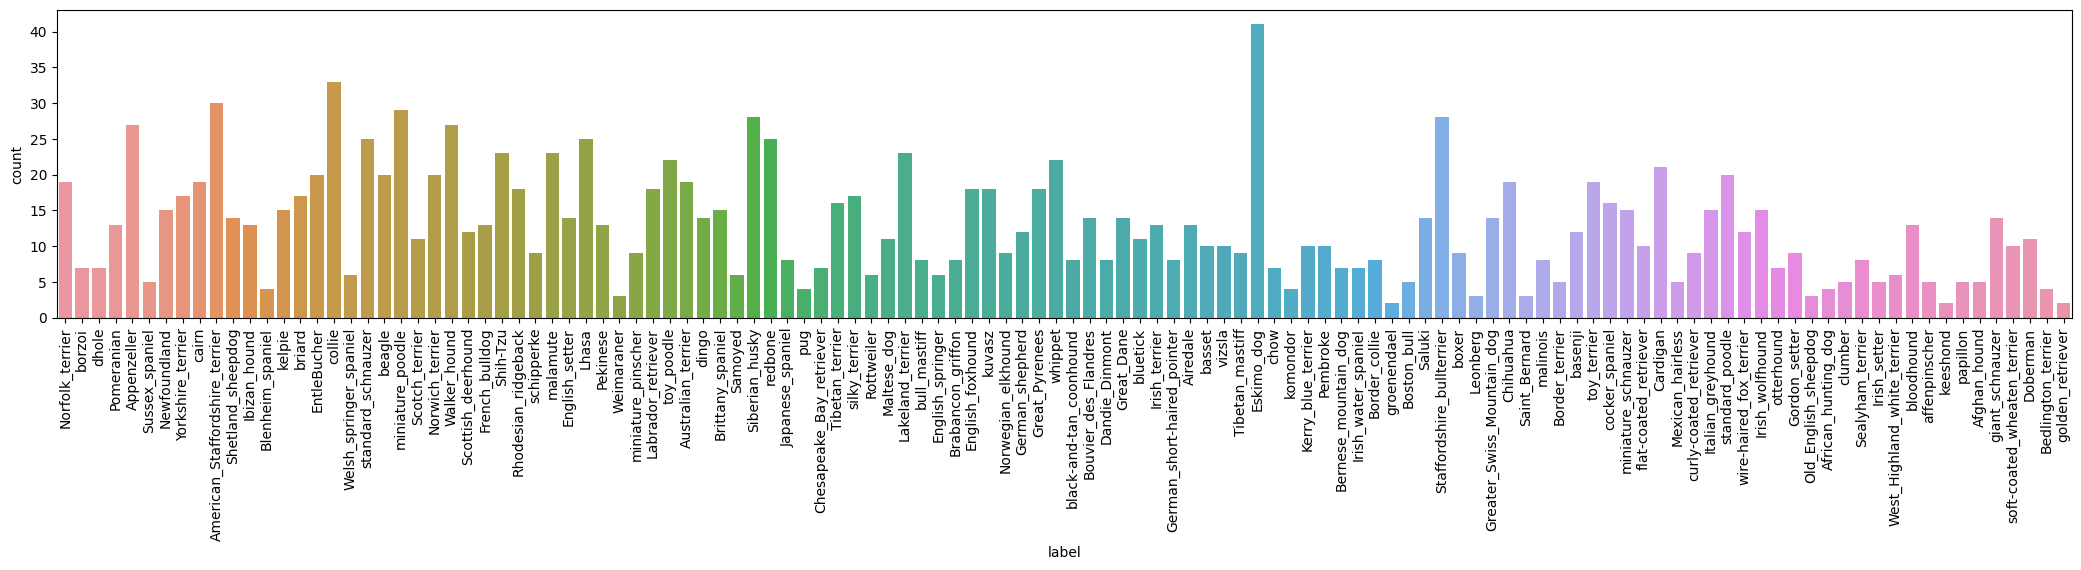

In [32]:
# 표에서 알 수 있듯이 자주 틀리는 품종이 있다.

%matplotlib inline

plt.figure(figsize=(26,4))
plt.xticks(rotation=90)

incorrect_result_df = test_df[test_df['gt_class'] != test_df['xcp_pred_class']]

sns.countplot(incorrect_result_df, x='label')

### EfficientNetB0 모델로 학습/검증/테스트 성능 평가 수행
* 먼저 기존 augmentation 기법을 기반으로 학습 진행
* 이후 학습 결과에 따라 여러 augmentation 기법 적용

In [33]:
# EfficientNetB0 모델의 preprocessing을 적용한 데이터세트 생성

from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input

effb0_tr_ds = Breed_Dataset(tr_path, tr_label,image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                        augmentor=augmentor_light, shuffle=True, pre_func=eff_preprocess_input)
effb0_val_ds = Breed_Dataset(val_path, val_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                        augmentor=None, shuffle=False, pre_func=eff_preprocess_input)
effb0_test_ds = Breed_Dataset(test_path, test_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                             augmentor=None, shuffle=False, pre_func=eff_preprocess_input)

train_image_batch = next(iter(effb0_tr_ds))[0]
valid_image_batch = next(iter(effb0_val_ds))[0]
test_image_batch = next(iter(effb0_test_ds))[0]

print(train_image_batch.shape)
print(valid_image_batch.shape)
print(test_image_batch.shape)

(64, 224, 224, 3)
(64, 224, 224, 3)
(64, 224, 224, 3)


In [34]:
N_EPOCHS = 15

def train_model_effb0(model_type, initial_lr=0.0001, augmentor=None, input_pre_func=None):    
    # model 생성
    model = create_model(model_type=model_type)
    model.compile(optimizer=Adam(learning_rate=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # callback 구현
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, model='min', verbose=1)
    ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
    
    # fit 진행 
    history = model.fit(effb0_tr_ds, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=effb0_val_ds, callbacks=([rlr_cb, ely_cb]), verbose=1)
    
    return model, history

In [35]:
effb0_model, effb0_history = train_model_effb0(model_type='efficientnetb0',initial_lr=0.0001,
                                         augmentor=augmentor_light, input_pre_func=eff_preprocess_input)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 221s 793ms/step - accuracy: 0.0703 - loss: 4.5439 - val_accuracy: 0.5198 - val_loss: 2.0531 - learning_rate: 1.0000e-04
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 55s 345ms/step - accuracy: 0.4851 - loss: 2.1941 - val_accuracy: 0.7312 - val_loss: 1.0790 - learning_rate: 1.0000e-04
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 55s 343ms/step - accuracy: 0.6776 - loss: 1.1284 - val_accuracy: 0.7628 - val_loss: 0.8442 - learning_rate: 1.0000e-04
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 55s 347ms/step - accuracy: 0.7526 - loss: 0.8383 - val_accuracy: 0.7842 - val_loss: 0.7307 - learning_rate: 1.0000e-04
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 56s 346ms/step - accuracy: 0.8011 - loss: 0.6344 - val_accuracy: 0.7830 - val_loss: 0.6865 - learning_rate: 1.0000e-04
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 338ms/step - accuracy: 0.8604 - loss: 0.4789 - val_accuracy: 0.7883 - val_loss: 0.6615 - learning_rate: 1.0000e-04
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 55s 345ms/step -

In [36]:
effb0_model.evaluate(effb0_test_ds, batch_size=BATCH_SIZE, verbose=1)

129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - accuracy: 0.8171 - loss: 0.6142


[0.6362768411636353, 0.8119533658027649]

In [37]:
# 테스트 dataset으로 개별 image들의 predict 수행
predict_result = effb0_model.predict(effb0_test_ds, batch_size=BATCH_SIZE, verbose=1)
predict_class = np.argmax(predict_result, axis=1)
test_df['effb0_pred_class'] = predict_class

129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 303ms/step


In [38]:
test_df.head(10)

path  \
8169       /kaggle/working/Images/n02111500-Great_Pyrenees/n02111500_7591.jpg   
18031             /kaggle/working/Images/n02110806-basenji/n02110806_1369.jpg   
4348           /kaggle/working/Images/n02096585-Boston_bull/n02096585_342.jpg   
879       /kaggle/working/Images/n02108551-Tibetan_mastiff/n02108551_2658.jpg   
19171     /kaggle/working/Images/n02094114-Norfolk_terrier/n02094114_2819.jpg   
3003               /kaggle/working/Images/n02090379-redbone/n02090379_980.jpg   
2068         /kaggle/working/Images/n02088094-Afghan_hound/n02088094_1254.jpg   
4665   /kaggle/working/Images/n02096294-Australian_terrier/n02096294_6258.jpg   
19168     /kaggle/working/Images/n02094114-Norfolk_terrier/n02094114_2206.jpg   
1090               /kaggle/working/Images/n02090622-borzoi/n02090622_7677.jpg   

                    label  gt_class  xcp_pred_class  effb0_pred_class  
8169       Great_Pyrenees        30              30                30  
18031             basenji        75              75                75  
4348          Boston_bull        11              11                25  
879       Tibetan_mastiff        67              67                67  
19171     Norfolk_terrier        47             111                73  
3003              redbone       109             109               109  
2068         Afghan_hound         0               0                 0  
4665   Australian_terrier         5               5                 5  
19168     Norfolk_terrier        47              47                47  
1090               borzoi        81              30                81

In [39]:
test_df[test_df['gt_class'] != test_df['effb0_pred_class']]['label'].value_counts()

label
Eskimo_dog                        37
collie                            35
miniature_poodle                  35
American_Staffordshire_terrier    30
Shih-Tzu                          29
                                  ..
African_hunting_dog                2
black-and-tan_coonhound            2
clumber                            2
keeshond                           1
Saint_Bernard                      1
Name: count, Length: 120, dtype: int64

### 추가로 augmentation, learning rate scheduler, fine tunning 설정

In [40]:
# 위에서 발생한 overfitting 문제 대응을 위해 보다 강력한 augmentation 적용
import albumentations as A

augmentor_heavy = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.2),
    A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2,0.2), p=0.2),
    A.CenterCrop(height=90, width=90, p=0.2),
    A.OneOf(
        [A.CoarseDropout(p=1, max_holes=26),
         A.CLAHE(p=1),
         A.Blur(blur_limit=(10,15), p=1)
        ], p=0.3)
])

In [41]:
# Learning rate scheduler에 적용할 함수 선언 및 callback 업데이트
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

def lrfn(epoch):
    # 내포 함수인 calc_fn()에 사용할 파라미터이다.
    LR_START = 1e-5
    LR_MAX = 1e-4
    LR_RAMPUP_EPOCHS = 2
    LR_SUSTAIN_EPOCHS = 1
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
        return lr
    
    # 반드시 내포 함수인 calc_fn(epoch)를 호출해야함. 
    return calc_fn(epoch)

# callbacks 재구성
lr_cb = LearningRateScheduler(lrfn, verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

callbacks_list = [lr_cb, ely_cb]

In [42]:
# 위에서 새롭게 만든 callbacks 적용 및 fine tunning 적용을 위해 학습용 함수 재구성
from tensorflow.keras import layers

def train_model_with_ft(model_type, initial_lr=0.0001, augmentor=None, callbacks_list=None, input_pre_func=None):
    # 새로운 augmentor을 적용한 dataset 생성
    effb0_tr_ds = Breed_Dataset(tr_path, tr_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                          augmentor=augmentor, shuffle=True, pre_func=input_pre_func)
    effb0_val_ds = Breed_Dataset(val_path, val_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                          augmentor=None, shuffle=False, pre_func=input_pre_func)
    
    # model 생성
    print('#####',model_type,' 생성 #####')
    model = create_model(model_type=model_type)
    model.compile(optimizer=Adam(learning_rate=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # feature extractor layer들을 freeze
    for layer in model.layers[:-4]:
        layer.trainable = False
    
    # feature extractor들이 아닌 이란 dense layer만 학습
    print('##### feature extractor freeze후 Dense layer만 학습 수행 ##### ')
    history = model.fit(effb0_tr_ds, epochs=7, validation_data=effb0_val_ds, callbacks=callbacks_list, verbose=1)
    
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            
    print('##### batchnormalization layer를 제외한 전체 layer unfreeze 후 학습 시작')
    history = model.fit(effb0_tr_ds, epochs=12, validation_data=effb0_val_ds, callbacks=callbacks_list, verbose=1)
    
    return model, history

In [43]:
effb0_model_ft, effb0_history_ft = train_model_with_ft(model_type='efficientnetb0',initial_lr=0.0001, augmentor=augmentor_heavy,
                                                 callbacks_list=callbacks_list, input_pre_func=eff_preprocess_input)

##### efficientnetb0  생성 #####
##### feature extractor freeze후 Dense layer만 학습 수행 ##### 

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/7


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 119s 561ms/step - accuracy: 0.0112 - loss: 4.8630 - val_accuracy: 0.0340 - val_loss: 4.6615 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 5.5e-05.
Epoch 2/7
155/155 ━━━━━━━━━━━━━━━━━━━━ 62s 386ms/step - accuracy: 0.0714 - loss: 4.5347 - val_accuracy: 0.4664 - val_loss: 3.7128 - learning_rate: 5.5000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/7
155/155 ━━━━━━━━━━━━━━━━━━━━ 62s 388ms/step - accuracy: 0.3129 - loss: 3.6105 - val_accuracy: 0.6684 - val_loss: 2.0392 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/7
155/155 ━━━━━━━━━━━━━━━━━━━━ 62s 383ms/step - accuracy: 0.4908 - loss: 2.4013 - val_accuracy: 0.7490 - val_loss: 1.2823 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/7
155/155 ━━━━━━━━━━━━━━━━━━━━ 62s 385ms/step - accuracy: 0.5549 - loss: 1.8825 - val_accuracy: 0.7652 - val

In [44]:
effb0_model_ft.evaluate(effb0_test_ds, batch_size=BATCH_SIZE, verbose=1)

129/129 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - accuracy: 0.8175 - loss: 0.6302


[0.6443557143211365, 0.8058794736862183]

### 새로운 augmentation 적용 후 학습

In [45]:
augmentor_light_02 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.2, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.2),
    A.ColorJitter(p=0.2)
])

In [46]:
effb0_model_ft, effb0_history_ft = train_model_with_ft(model_type='efficientnetb0',initial_lr=0.0001, augmentor=augmentor_light_02,
                                                 callbacks_list=callbacks_list, input_pre_func=eff_preprocess_input)

##### efficientnetb0  생성 #####
##### feature extractor freeze후 Dense layer만 학습 수행 ##### 

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/7
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 551ms/step - accuracy: 0.0132 - loss: 4.8419 - val_accuracy: 0.0437 - val_loss: 4.6326 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 5.5e-05.
Epoch 2/7
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 378ms/step - accuracy: 0.0950 - loss: 4.4405 - val_accuracy: 0.5320 - val_loss: 3.5168 - learning_rate: 5.5000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/7
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 381ms/step - accuracy: 0.4201 - loss: 3.1820 - val_accuracy: 0.7154 - val_loss: 1.7230 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/7
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 382ms/step - accuracy: 0.6060 - loss: 1.8004 - val_accuracy: 0.7579 - val_loss: 1.1125 - learning_rate: 1.0000e-04

Epoch 5: Learning

In [47]:
effb0_model_ft.evaluate(effb0_test_ds, batch_size=BATCH_SIZE, verbose=1)

129/129 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - accuracy: 0.8177 - loss: 0.6051


[0.6194878816604614, 0.8080660700798035]